In [43]:
from Gaugi.monet.TAxisFunctions import *
from Gaugi.monet.PlotFunctions import *
from Gaugi.monet import ATLASLabel
from Gaugi.monet.utils import NormHist, getColor
from ROOT import TH1F,TCanvas, TFile, TPad, TColor
from ROOT import kBlack,kBlue,kRed,kAzure,kGreen,kMagenta,kCyan,kOrange,kGray,kYellow
import numpy as np
import array
import os
from pprint import pprint
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from Gaugi.monet.AtlasStyle import SetAtlasStyle
SetAtlasStyle()


Applying ATLAS style settings...


In [2]:
etbins = [15, 20, 30, 40, 50, 1000000]
etabins = [0.0, 0.8, 1.37, 1.54, 2.37, 2.50]

In [3]:
def get_models( location , etbins, etabins, remove_last=True):
    from tensorflow.keras.models import Model, model_from_json
    from tensorflow.keras.layers import Activation
    import json
    models = [[ None for _ in range(len(etabins)-1)] for __ in range(len(etbins)-1)]
    for et_bin in range(len(etbins)-1):
        for eta_bin in range(len(etabins)-1):
            d_tuned = {}
            path=location.format(ET=et_bin,ETA=3 if eta_bin==4 else eta_bin)
            #print(path)
            with open(path+'.json', 'r') as json_file:
                model = model_from_json(json_file.read())
                # load weights into new model
                model.load_weights(path+".h5")
                # since the production version has no tansig fucntion as default. Let's include it
                # for study
                model.add(Activation('tanh'))
                new_model = Model(model.inputs, model.layers[-2].output) if remove_last else model
                d_tuned['model']    = new_model
                d_tuned['etBin']    = [etbins[et_bin], etbins[et_bin+1]]
                d_tuned['etaBin']   = [etabins[eta_bin], etabins[eta_bin+1]]
                d_tuned['etBinIdx'] = et_bin
                d_tuned['etaBinIdx']= eta_bin
                models[et_bin][eta_bin] = d_tuned
                
    # return the models's matrix          
    return models

model_path = '/Volumes/castor/tuning_data/Zee/production/TrigL2_20170505_v6/models'
model_path+='/mc15_13TeV.423300.Zee_probes_lhmedium.423300.JF17_Truth.model_v6.electronTight.et{ET}_eta{ETA}'
best_models = get_models(model_path, etbins, etabins,remove_last=True)

In [5]:
path = '/Volumes/castor/cern_data/files/Zee/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17/'
path+= 'mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17_et{ET}_eta{ETA}.npz'
mc_paths = [[ path.format(ET=et,ETA=eta) for eta in range(5)] for et in range(5)] 

In [7]:
path = '/Volumes/castor/cern_data/files/Zee/data16_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.GRL_v97.mc15_13TeV.bkg.Truth.JF17/'
path+= 'data16_13TeV.AllPeriods.sgn.probes_lhmedium.GRL_v97.mc15_13TeV.bkg.Truth.JF17_et{ET}_eta{ETA}.npz'
data_paths = [[ path.format(ET=et,ETA=eta) for eta in range(5)] for et in range(5)]

In [56]:
def get_nn_output( _path, _model ):
    from Gaugi import load
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    from Gaugi import load
    d = load(_path)
    # extract rings
    data_rings = norm1(d['data'][:,1:101])
    target = d['target']
    output = _model.predict(data_rings,batch_size=1024, verbose=1).flatten()
    return output, target

In [57]:
mc_outputs , mc_target= get_nn_output(mc_paths[2][0], best_models[2][0]['model'])
mc_outputs.shape

120/120 [==============================] - 0s 957us/step


(121879,)

In [58]:
data_outputs , data_target = get_nn_output(data_paths[2][0], best_models[2][0]['model'])
data_outputs.shape

1155/1155 [==============================] - 1s 812us/step


(1182602,)

In [38]:
def AddLegend(canvas, x, y, legends):
    MakeLegend( canvas,x,y,x+0.48,y+0.20,textsize=16, names=legends, option = 'f' )

In [111]:
def plot_mc_versus_data( _mc_outputs, _data_outputs , xbins, xmin, xmax , 
                          these_color_fill, these_color_line, normalize=False, y_maximum=None):
    
    mc = TH1F( 'mc', '', xbins, xmin, xmax )
    w = array.array( 'd', np.ones_like( _mc_outputs ) )
    mc.FillN( len(_mc_outputs), array.array('d',  _mc_outputs.tolist()), w)  
    pp = TH1F( 'data', '', xbins, xmin, xmax )
    w = array.array( 'd', np.ones_like( _data_outputs ) )
    pp.FillN( len(_data_outputs), array.array('d',  _data_outputs.tolist()), w)
    
    canvas = TCanvas('canvas',"",700, 500)
    if normalize:
        mc = NormHist(mc)
        pp = NormHist(pp)
    mc.SetLineColor(these_color_line[0])
    mc.SetFillColor(these_color_fill[0])
    if y_maximum:
        mc.SetMaximum(y_maximum)
    pp.SetLineColor(these_color_line[1])
    pp.SetFillColor(these_color_fill[1])
    if y_maximum:
        pp.SetMaximum(y_maximum)
    AddHistogram(canvas,mc, 'same')
    AddHistogram(canvas,pp, 'same')    
    FormatCanvasAxes(canvas, XLabelSize=16, YLabelSize=16, XTitleOffset=0.87, ZLabelSize=16,
                             ZTitleSize=16, YTitleOffset=1.20, ZTitleOffset=1.1)
    SetAxisLabels(canvas,'Neural Network Output (Discriminant)', 'counts/bin (norm by counts)', 'Data/MC')
    return canvas

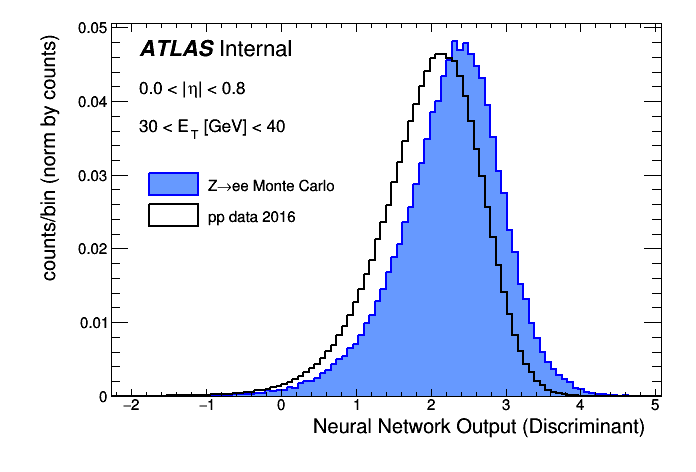

In [125]:
color_fill = [kAzure-4,0]
color_line = [kBlue, kBlack]

canvas = plot_mc_versus_data(mc_outputs[mc_target==1], data_outputs[data_target==1], 
                             100, -2.2, 5.0, color_fill, color_line, normalize=True)

AddATLASLabel(canvas, 0.2, 0.88, 'Internal')
AddTexLabel(canvas, 0.2, 0.80, '0.0 < |#eta| < 0.8', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.72, '30 < E_{T} [GeV] < 40', textsize=0.04)
AddLegend( canvas,0.2,0.51, ['Z#rightarrowee Monte Carlo', 'pp data 2016'])
canvas.Draw()
canvas.SaveAs("nn_output_mc15_versus_data16_et2_eta0.pdf")